# Store item forcast - lgb

In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import gc
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import lightgbm as lgb
plt.style.use('ggplot')
%matplotlib inline
seed = 234

## Load dataset

In [2]:
path ='dataset/'
#path ='../input/'
train = pd.read_csv(path + 'train.csv',parse_dates=[0],nrows=None)
test = pd.read_csv(path+ 'test.csv',parse_dates=[1], nrows=None )
print('Number of rows and columns in train dataset are:',train.shape)
print('Number of rows and columns in train dataset are:', test.shape)

Number of rows and columns in train dataset are: (913000, 4)
Number of rows and columns in train dataset are: (45000, 4)


## Exploratory data analysis

In [3]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


The test dataset contains id column but train dataset does not contains id column. While importing dataset parse_date is assigned with perticular column index.

In [5]:
def basic_details(df):
    """Find number of missing value,dtyeps, unique value in 
    dataset"""
    k = pd.DataFrame()
    k['Missing value'] = df.isnull().sum()
    k['% Missing value'] = df.isnull().sum()/df.shape[0]
    k['dtype'] = df.dtypes
    k['N unique'] = df.nunique()
    return k

basic_details(train) # train dataset

,Missing value,% Missing value,dtype,N unique
date,0,0.0,datetime64[ns],1826
store,0,0.0,int64,10
item,0,0.0,int64,50
sales,0,0.0,int64,213


In [6]:
basic_details(test) # test dataset

,Missing value,% Missing value,dtype,N unique
id,0,0.0,int64,45000
date,0,0.0,datetime64[ns],90
store,0,0.0,int64,10
item,0,0.0,int64,50


In [7]:
train.describe() # descriptive statistics about features

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


There are 50 diffirent item in 10 diffirent stores. The maximum number of items sold is 231 and average item sold is 52.25.

## Date
Let's extract day, week, month, year from date feature

In [8]:
print('Time series start time: "{}" and end time: "{}"'.format(train['date'].min(), train['date'].max()))
print('Time series start time: "{}" and end time: "{}"'.format(test['date'].min(), test['date'].max()))

Time series start time: "2013-01-01 00:00:00" and end time: "2017-12-31 00:00:00"
Time series start time: "2018-01-01 00:00:00" and end time: "2018-03-31 00:00:00"


In [9]:
#train['date'] = pd.to_datetime(train['date'])
train['day'] = train['date'].dt.day
train['dayofweek'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['weekofyear'] = train['date'].dt.weekofyear
train['is_month_start'] = train['date'].dt.is_month_start.astype('int8')
train['is_month_end'] = train['date'].dt.is_month_end.astype('int8')


test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year
test['weekofyear'] = test['date'].dt.weekofyear
test['is_month_start'] = test['date'].dt.is_month_start.astype('int8')
test['is_month_end'] = test['date'].dt.is_month_end.astype('int8')

train.head()

,date,store,item,sales,day,dayofweek,month,year,weekofyear,is_month_start,is_month_end
0,2013-01-01,1,1,13,1,1,1,2013,1,1,0
1,2013-01-02,1,1,11,2,2,1,2013,1,0,0
2,2013-01-03,1,1,14,3,3,1,2013,1,0,0
3,2013-01-04,1,1,13,4,4,1,2013,1,0,0
4,2013-01-05,1,1,10,5,5,1,2013,1,0,0


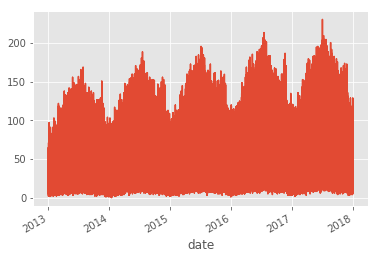

In [10]:
train.set_index('date')['sales'].plot(kind='line')

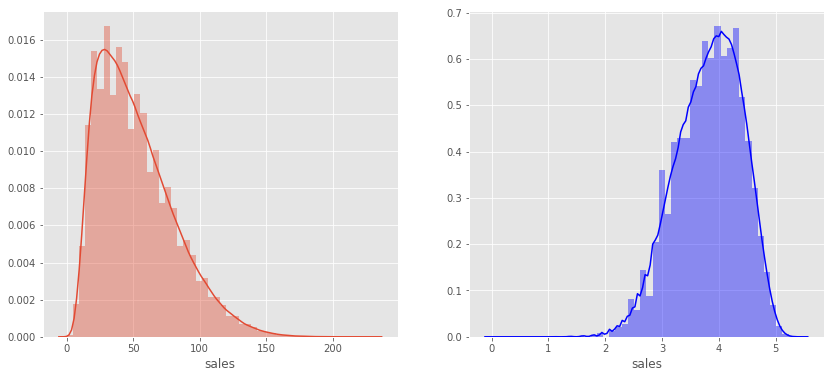

In [11]:
f,ax = plt.subplots(1,2,figsize=(14,6))
sns.distplot(train['sales'],ax =ax[0])
sns.distplot(np.log(train['sales']+1),ax=ax[1], color='b')

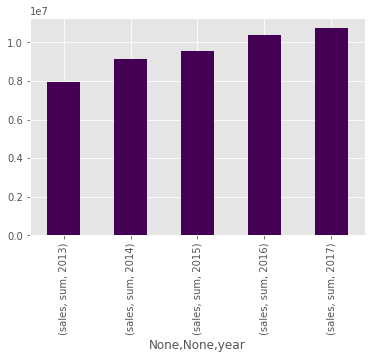

In [12]:
(train
 .groupby(['year',])
 .agg({'sales':['sum']})
 .unstack()
 .plot(kind='bar',cmap='viridis'))

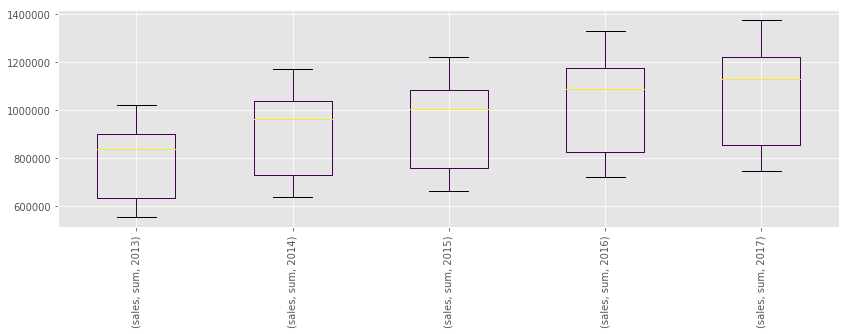

In [13]:
(train
 .groupby(['store','year'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,4),kind='box',stacked=True,cmap='viridis'))
plt.xticks(rotation=90);

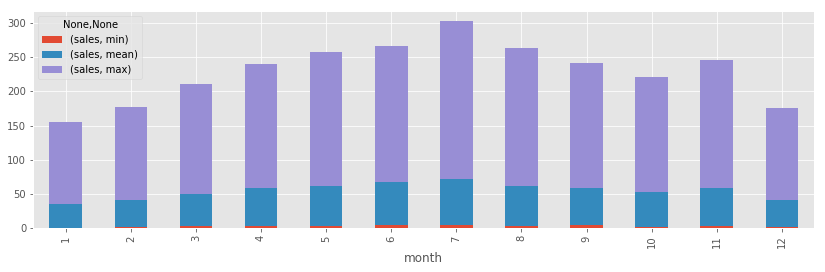

In [14]:
(train.groupby('month')
.agg({'sales':['min','mean','max']})
 .plot(figsize=(14,4),kind='bar',stacked=True))

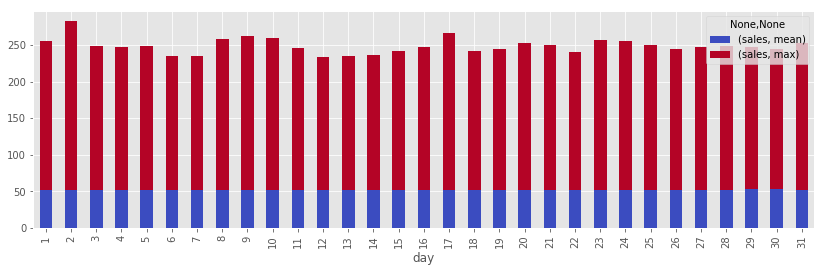

In [15]:
(train
.groupby(['day'])
.agg({'sales':['mean','max']})
.plot(figsize=(14,4),kind='bar',stacked=True,cmap='coolwarm'))

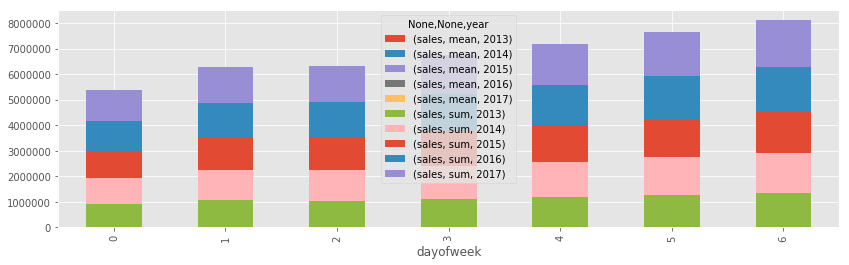

In [16]:
(train
.groupby(['dayofweek','year'])
 .agg({'sales':['mean','sum']})
 .unstack()
 .plot(figsize=(14,4),kind='bar',stacked=True))

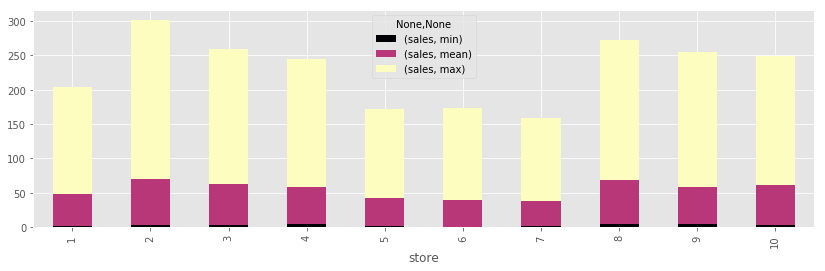

In [17]:
(train
 .groupby('store')
 .agg({'sales':['min','mean','max']})
 .plot(figsize=(14,4),kind='bar',stacked=True,cmap='magma'))

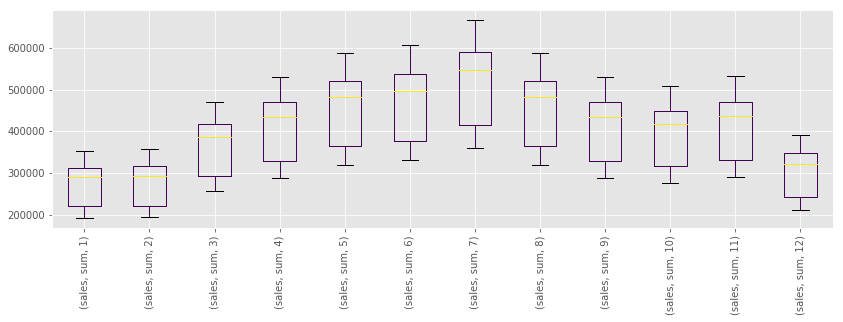

In [18]:
(train
 .groupby(['store','month'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,4),kind='box',stacked=True,cmap='viridis'))
plt.xticks(rotation=90);

## item

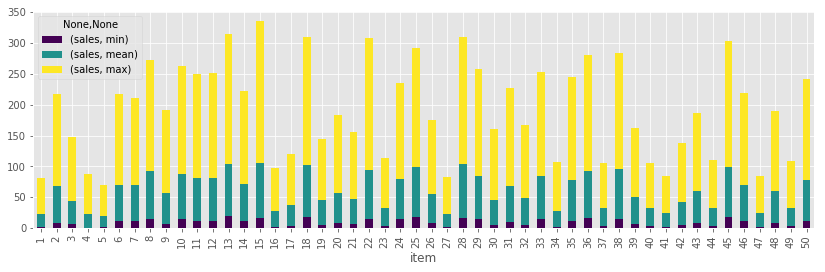

In [19]:
(train
 .groupby('item')
 .agg({'sales':['min','mean','max']})
 .plot(figsize=(14,4),kind='bar',stacked=True,cmap='viridis'))

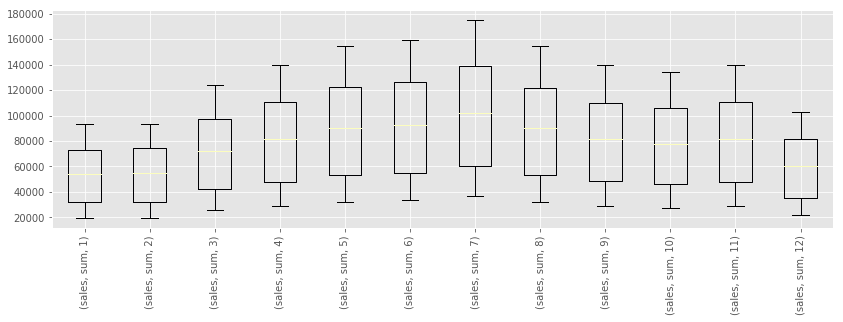

In [20]:
(train
 .groupby(['item','month'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,4),kind='box',stacked=True,cmap='magma'))
plt.xticks(rotation=90);

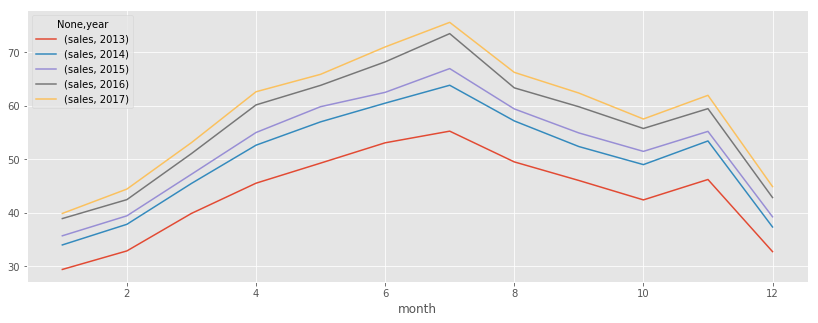

In [21]:
(train
 .groupby(['month','year'])
 .agg({'sales':'mean'})
 .unstack()
 .plot(figsize=(14,5)))

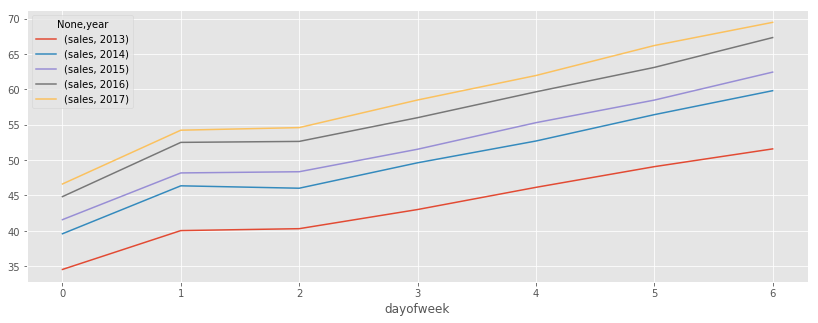

In [22]:
(train
 .groupby(['dayofweek','year'])
 .agg({'sales':'mean'})
 .unstack()
 .plot(figsize=(14,5)))

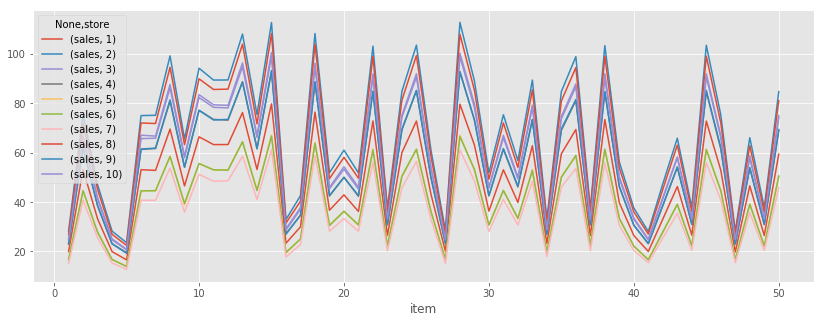

In [23]:
(train
 .groupby(['item','store'])
 .agg({'sales':'mean'})
 .unstack()
 .plot(figsize=(14,5),kind='line'))

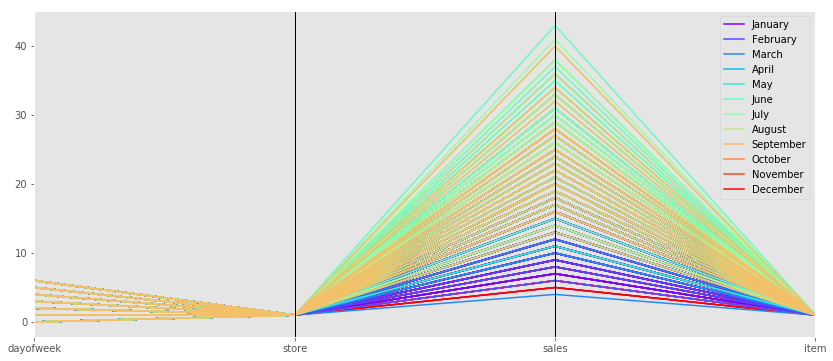

In [24]:
train1 =train.copy()
train1['month'] = train1['date'].dt.month_name()
plt.figure(figsize=(14,6))
pd.plotting.parallel_coordinates(train1[['dayofweek','store','sales','item','month']][:1000]
                                 ,'month',colormap='rainbow')
del train1

## Rolling window

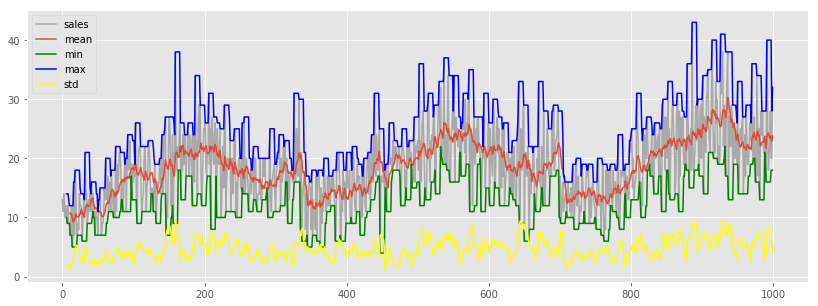

In [25]:
plt.figure(figsize=(14,5))
train['sales'].head(1000).plot(color='darkgray')
train['sales'].head(1000).rolling(window=12).mean().plot(label='mean')
#train['sales'].head(1000).rolling(window=12).median().plot(label='median')
train['sales'].head(1000).rolling(window=7).min().plot(label='min',color='g')
train['sales'].head(1000).rolling(window=7).max().plot(label='max',color='b')
train['sales'].head(1000).rolling(window=7).std().plot(label='std',color='yellow')
plt.legend()

## Expanding window

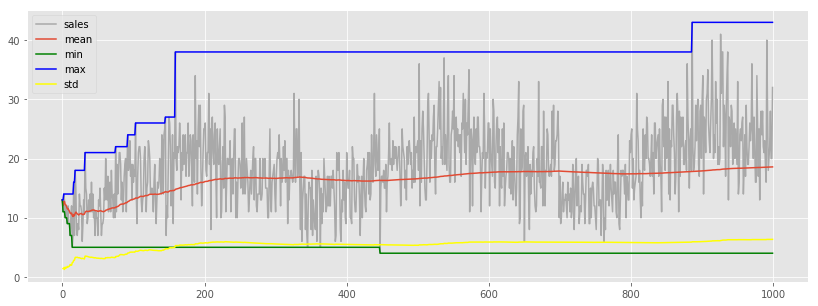

In [26]:
# Expanding window
plt.figure(figsize=(14,5))
train['sales'].head(1000).plot(color='darkgray')
train['sales'].head(1000).expanding().mean().plot(label='mean')
#train['sales'].head(1000).rolling(window=12).median().plot(label='median')
train['sales'].head(1000).expanding().min().plot(label='min',color='g')
train['sales'].head(1000).expanding().max().plot(label='max',color='b')
train['sales'].head(1000).expanding().std().plot(label='std',color='yellow')
plt.legend()

## Combine train and test dataset

In [27]:
train['id'] = np.nan
train['is_train'] = True
test['is_train'] = False
test['sales'] = np.nan

# concat train,test
train_test = pd.concat([train,test],axis=0)

#Log transform
train_test['sales_log'] = np.log(train_test['sales']+1)
gc.collect()
train_test.shape

/home/sudhir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


(958000, 14)

### Aggregate

In [29]:
def aggregate_groupby(df,columns,on):
    "ON target variable sales"
    agg = df.groupby(columns).agg({on:['min','max','sum','mean','median','std']})
    agg.columns = pd.Index(['_&_'.join(columns)+ '_'+'_&_'.join(e) for e in agg.columns.tolist()])
    df = pd.merge(df, agg, how= 'left',on= columns)
    return df

In [30]:
train_test = aggregate_groupby(train_test,columns=['store','day',],on='sales')
train_test = aggregate_groupby(train_test,columns=['store','month',],on='sales')
train_test = aggregate_groupby(train_test,columns=['store','dayofweek',],on='sales')

train_test = aggregate_groupby(train_test,columns=['item','day',],on='sales')
train_test = aggregate_groupby(train_test,columns=['item','month',],on='sales')
train_test = aggregate_groupby(train_test,columns=['item','dayofweek',],on='sales')
train_test = aggregate_groupby(train_test,columns=['item','store',],on='sales')

train_test.shape

(958000, 56)

In [32]:
train_test = aggregate_groupby(train_test,columns=['store','day',],on='sales_log')
train_test = aggregate_groupby(train_test,columns=['store','month',],on='sales_log')
train_test = aggregate_groupby(train_test,columns=['store','dayofweek',],on='sales_log')

train_test = aggregate_groupby(train_test,columns=['item','day',],on='sales_log')
train_test = aggregate_groupby(train_test,columns=['item','month',],on='sales_log')
train_test = aggregate_groupby(train_test,columns=['item','dayofweek',],on='sales_log')
train_test = aggregate_groupby(train_test,columns=['item','store',],on='sales_log')

train_test.shape

(958000, 68)

### Rolling and ewm aggregate

In [93]:
def extract_precedent_statistics(df, on, group_by):
    
    df.sort_values(group_by + ['date'], inplace=True)
    
    groups = df.groupby(group_by, sort=False)
    
    stats = {
        'mean': [],
        'median': [],
        'std': [],
        'count': [],
        'max': [],
        'min': []
    }
    
    exp_alphas = [0.1, 0.25, 0.3, 0.5, 0.75]
    stats.update({'exp_{}_mean'.format(alpha): [] for alpha in exp_alphas})
    
    for _, group in groups:
        
        shift = group[on].shift()
        roll = shift.rolling(window=len(group), min_periods=1)
        
        stats['mean'].extend(roll.mean())
        stats['median'].extend(roll.median())
        stats['std'].extend(roll.std())
        stats['count'].extend(roll.count())
        stats['max'].extend(roll.max())
        stats['min'].extend(roll.min())
        
        for alpha in exp_alphas:
            exp = shift.ewm(alpha=alpha, adjust=False)
            stats['exp_{}_mean'.format(alpha)].extend(exp.mean())
    
    suffix = '_&_'.join(group_by)
    
    for stat_name, values in stats.items():
        df['{}_{}_by_{}'.format(on, stat_name, suffix)] = values


In [94]:
"""extract_precedent_statistics( df=train_test,on='sales',group_by=['store', 'day'])
extract_precedent_statistics( df=train_test,on='sales',group_by=['store', 'dayofweek'])
extract_precedent_statistics( df=train_test,on='sales',group_by=['item', 'day'])
extract_precedent_statistics( df=train_test,on='sales',group_by=['item', 'dayofweek'])
extract_precedent_statistics( df=train_test,on='sales',group_by=['store', 'item'])
gc.collect()
train_test.shape"""

(2000, 69)

In [95]:
"""extract_precedent_statistics( df=train_test,on='sales_log',group_by=['store', 'day'])
extract_precedent_statistics( df=train_test,on='sales_log',group_by=['store', 'dayofweek'])
extract_precedent_statistics( df=train_test,on='sales_log',group_by=['item', 'day'])
extract_precedent_statistics( df=train_test,on='sales_log',group_by=['item', 'dayofweek'])
extract_precedent_statistics( df=train_test,on='sales_log',group_by=['store', 'item'])
gc.collect()
train_test.shape"""

(2000, 124)

### One hot encoding

In [96]:
def one_hot_encoding(df,columns):
    print('Original shape',df.shape)
    df = pd.get_dummies(df,drop_first=True,columns=columns)
    print('After OHE', df.shape)
    return df

In [97]:
gc.collect()
train_test = one_hot_encoding(train_test,columns=['month','dayofweek'])

Original shape (2000, 124)
After OHE (2000, 139)


In [98]:
#plt.figure(figsize=(14,10))
#sns.heatmap(train_test1.corr(), cmap='coolwarm', annot=True,fmt='.2f')

## Model selection

In [99]:
# Model
from sklearn.model_selection import train_test_split
col_drop = ['id','is_train','sales','sales_log']
X = train_test[train_test['is_train'] == True].drop(col_drop +['date'],axis=1)
y = train_test[train_test['is_train'] == True]['sales_log']
test_new = train_test[train_test['is_train'] == False].drop(col_drop +['date'],axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state= seed)
gc.collect()
X.shape,test_new.shape

((1000, 134), (1000, 134))

## Model

In [124]:
def lgb_model(X_train, X_valid, y_valid, y_test,test_new):
    lgb_param = {}
    lgb_param['boosting_type'] ='gbdt'
    lgb_param['max_depth'] = 7
    lgb_param['num_leaves'] = 2**7
    lgb_param['learning_rate'] = 0.1
    lgb_param['n_estimators'] = 3
    lgb_param['feature_fraction'] = 0.9
    lgb_param['bagging_fraction'] = 0.9
    lgb_param['lambda_l1'] = 0.06
    lgb_param['lambda_l2'] =  0.1
    lgb_param['random_state'] = seed
    lgb_param['n_jobs'] = 4
    lgb_param['silent'] = -1
    lgb_param['verbose'] = -1
    
    model = lgb.LGBMRegressor(**lgb_param)
    print('-'*10,'*'*20,'-'*10)
    model.fit(X_train,y_train, eval_set= [(X_train,y_train),(X_valid,y_valid)],
              eval_metric ='rmse',early_stopping_rounds=20,verbose=100)
    
    y_pred = model.predict(X_valid)
    print('Root mean_squared_error','-'*20 ,np.sqrt(mean_squared_error(y_valid, y_pred)))
    y_pred_new = model.predict(test_new)
    return y_pred_new, model

In [125]:
y_pred_new, model = lgb_model(X_train, X_valid, y_valid, y_valid,test_new)

---------- ******************** ----------
Training until validation scores don't improve for 20 rounds.
Did not meet early stopping. Best iteration is:
[3]	training's rmse: 0.319209	valid_1's rmse: 0.340777
Root mean_squared_error -------------------- 0.340777364289


In [112]:
# Model evaluation
#print('Root mean_squared_error',np.sqrt(mean_squared_error(y_test, y_pred)))

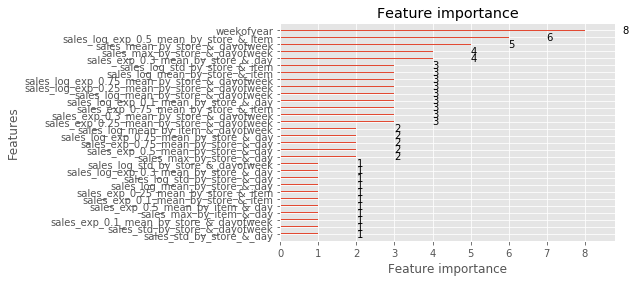

In [137]:
# Feature importance
lgb.plot_importance(model,max_num_features=100);

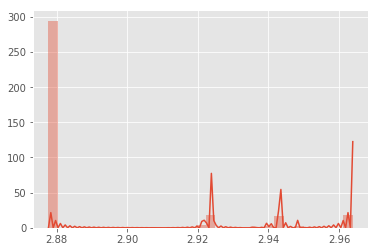

In [122]:
sns.distplot(y_pred_new)

In [134]:
y_pred_new1 = np.exp(y_pred_new)-1
submit = pd.DataFrame({'id': test['id'], 'sales':y_pred_new1})
submit.to_csv('store_submit.csv',index=False)
submit.head()

,id,sales
0,0,17.984267
1,1,17.975955
2,2,17.975955
3,3,17.985232
4,4,17.975955


# Thank you